In [1]:
pip install ucimlrepo

In [3]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
wine_quality = fetch_ucirepo(id=186)

# data (as pandas dataframes)
X = wine_quality.data.features
Y = wine_quality.data.targets

# metadata
print(wine_quality.metadata)

# variable information
print(wine_quality.variables)


{'uci_id': 186, 'name': 'Wine Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/186/wine+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/186/data.csv', 'abstract': 'Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests (see [Cortez et al., 2009], http://www3.dsi.uminho.pt/pcortez/wine/).', 'area': 'Business', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 4898, 'num_features': 11, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['quality'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Wed Nov 15 2023', 'dataset_doi': '10.24432/C56S3T', 'creators': ['Paulo Cortez', 'A. Cerdeira', 'F. Almeida', 'T. Matos', 'J. Reis'], 'intro_paper': {'ID': 252, 'type': 'NATIVE', 'title': 'Modeling wine preferences


========= Dataset summary ========= 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB

========= A few first samples ========= 

   fixed acidity  volatile acidity  citric a

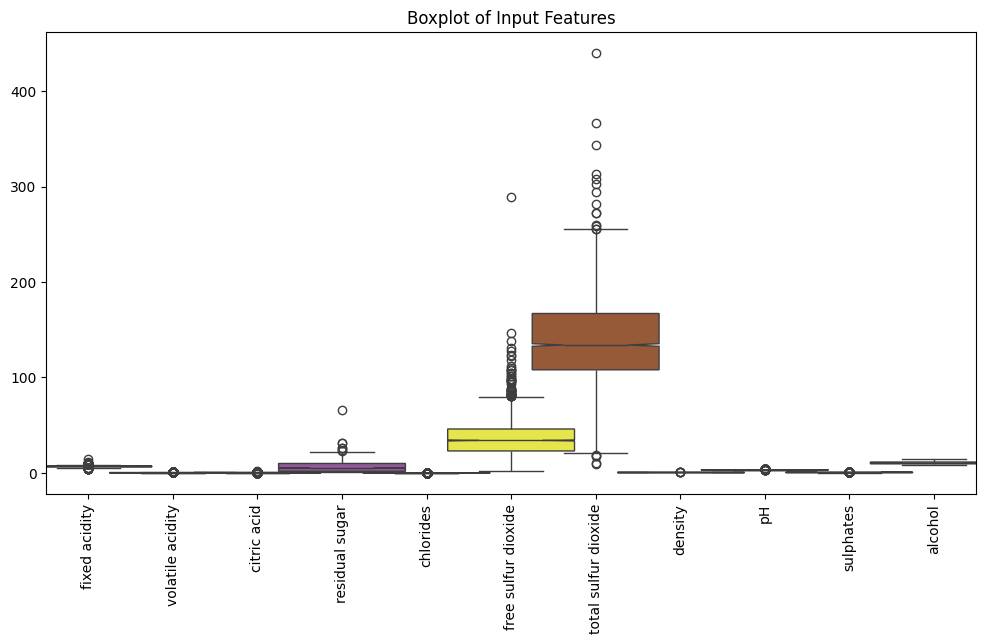

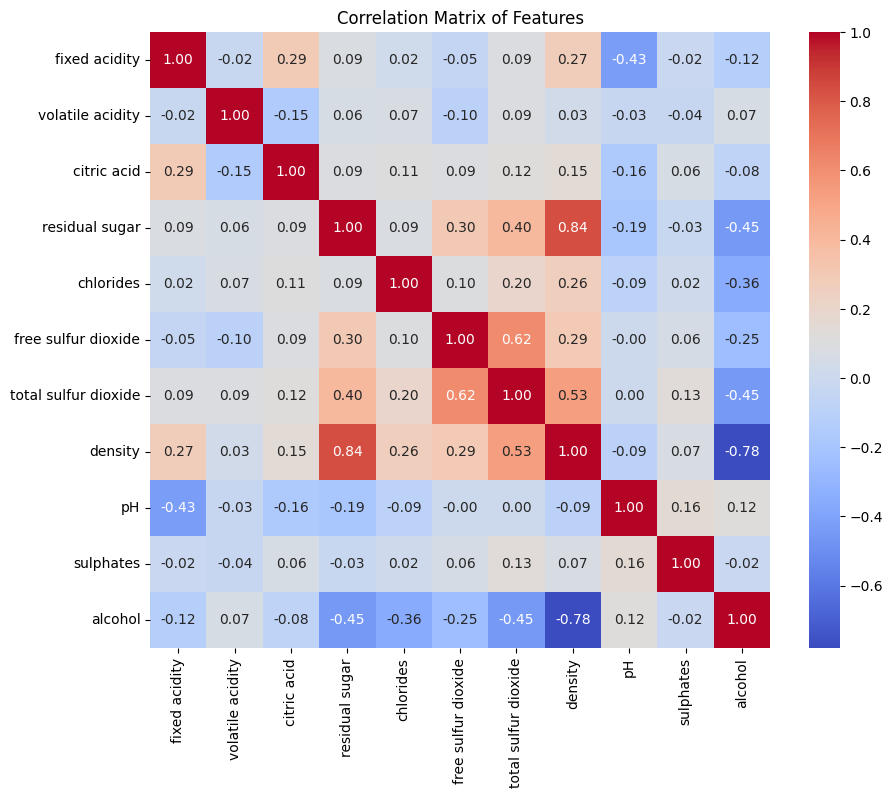


========= Sizes =========
Training: (1632, 11), Validation: (1633, 11), Test: (1633, 11)

Validation error for k=3: 0.3307


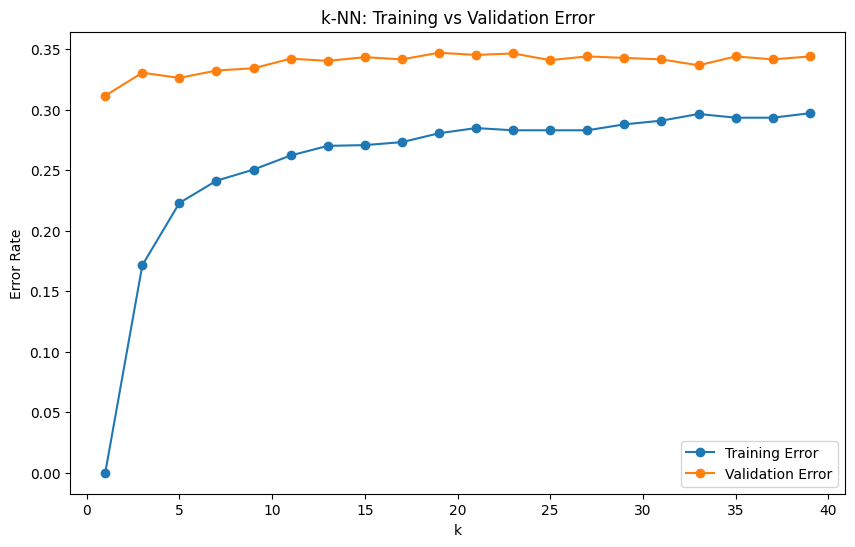

Optimal k (based on validation error): 1, with error: 0.3117
Test error with k=1: 0.3215


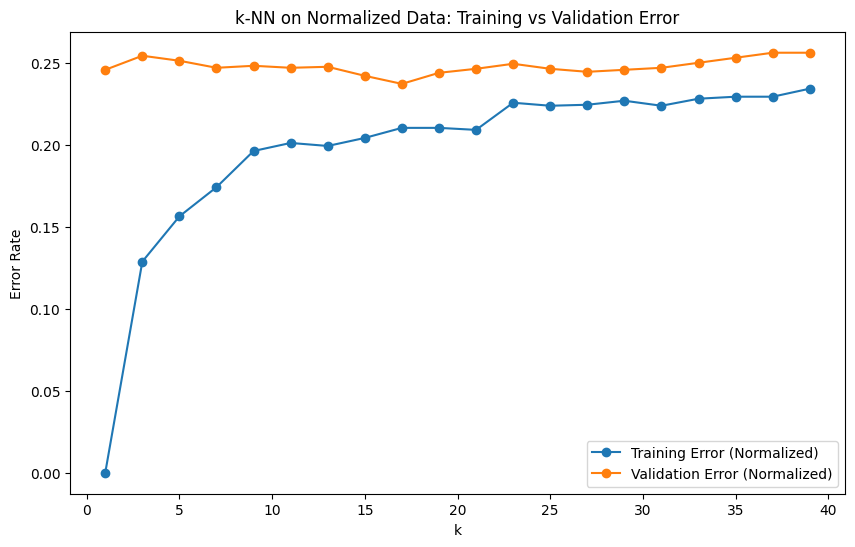

Test error (normalized data) with k=1: 0.2609


In [9]:
# ==============================
# 1. Data Analysis
# ==============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
link = "http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
df = pd.read_csv(link, header="infer", delimiter=";")

# Dataset summary
print("\n========= Dataset summary ========= \n")
df.info()
print("\n========= A few first samples ========= \n")
print(df.head())

# Form input and output arrays
X = df.drop("quality", axis=1)
Y = df["quality"]

print("\n========= Wine Qualities ========= \n")
print(Y.value_counts())

# Convert to binary classification: 0 = bad (<=5), 1 = good (>5)
Y = np.array([0 if val <= 5 else 1 for val in Y])
print("\n========= Samples per class ========= \n")
print(pd.Series(Y).value_counts())

# Statistical analysis
plt.figure(figsize=(12,6))
sns.boxplot(data=X, orient="v", palette="Set1", width=1.5, notch=True)
plt.xticks(rotation=90)
plt.title("Boxplot of Input Features")
plt.show()

plt.figure(figsize=(10,8))
corr = X.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Features")
plt.show()

# ==============================
# 2. Classification
# ==============================
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# 2.1 Data split
# First split into training+validation (2/3) and test (1/3)
Xa, Xt, Ya, Yt = train_test_split(X, Y, test_size=1/3, shuffle=True, stratify=Y, random_state=42)
# Split training into training and validation (1/2 of training)
Xa, Xv, Ya, Yv = train_test_split(Xa, Ya, test_size=0.5, shuffle=True, stratify=Ya, random_state=42)

print("\n========= Sizes =========")
print(f"Training: {Xa.shape}, Validation: {Xv.shape}, Test: {Xt.shape}")

# 2.2 k-NN Classification
# Starter k = 3
k = 3
clf = KNeighborsClassifier(n_neighbors=k)
clf.fit(Xa, Ya)
Ypred_v = clf.predict(Xv)
error_v = 1 - accuracy_score(Yv, Ypred_v)
print(f"\nValidation error for k={k}: {error_v:.4f}")

# Evaluate for multiple k
k_vector = np.arange(1, 40, 2)
error_train = []
error_val = []

for k in k_vector:
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(Xa, Ya)
    Ypred_train = clf.predict(Xa)
    Ypred_val = clf.predict(Xv)
    error_train.append(1 - accuracy_score(Ya, Ypred_train))
    error_val.append(1 - accuracy_score(Yv, Ypred_val))

# Plot training and validation error
plt.figure(figsize=(10,6))
plt.plot(k_vector, error_train, label="Training Error", marker='o')
plt.plot(k_vector, error_val, label="Validation Error", marker='o')
plt.xlabel("k")
plt.ylabel("Error Rate")
plt.title("k-NN: Training vs Validation Error")
plt.legend()
plt.show()

# Select best k
err_min = np.min(error_val)
ind_opt = np.argmin(error_val)
k_star = k_vector[ind_opt]
print(f"Optimal k (based on validation error): {k_star}, with error: {err_min:.4f}")

# Test error with optimal k
clf_opt = KNeighborsClassifier(n_neighbors=k_star)
clf_opt.fit(Xa, Ya)
Ypred_test = clf_opt.predict(Xt)
error_test = 1 - accuracy_score(Yt, Ypred_test)
print(f"Test error with k={k_star}: {error_test:.4f}")

# 2.3 Normalize the data
sc = StandardScaler(with_mean=True, with_std=True)
sc.fit(Xa)
Xa_n = sc.transform(Xa)
Xv_n = sc.transform(Xv)
Xt_n = sc.transform(Xt)

# Repeat k-NN on normalized data
error_train_n = []
error_val_n = []

for k in k_vector:
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(Xa_n, Ya)
    Ypred_train_n = clf.predict(Xa_n)
    Ypred_val_n = clf.predict(Xv_n)
    error_train_n.append(1 - accuracy_score(Ya, Ypred_train_n))
    error_val_n.append(1 - accuracy_score(Yv, Ypred_val_n))

# Plot normalized errors
plt.figure(figsize=(10,6))
plt.plot(k_vector, error_train_n, label="Training Error (Normalized)", marker='o')
plt.plot(k_vector, error_val_n, label="Validation Error (Normalized)", marker='o')
plt.xlabel("k")
plt.ylabel("Error Rate")
plt.title("k-NN on Normalized Data: Training vs Validation Error")
plt.legend()
plt.show()

# Test error with normalization and optimal k
clf_opt_n = KNeighborsClassifier(n_neighbors=k_star)
clf_opt_n.fit(Xa_n, Ya)
Ypred_test_n = clf_opt_n.predict(Xt_n)
error_test_n = 1 - accuracy_score(Yt, Ypred_test_n)
print(f"Test error (normalized data) with k={k_star}: {error_test_n:.4f}")


# Task
Analyze the performance of the k-NN model by comparing the test error rates before and after data normalization. Generate a confusion matrix for the optimal k-NN model trained on the normalized data to understand its classification performance. Summarize the findings, highlighting the impact of normalization and insights from the confusion matrix.

## Analyze Model Performance

### Subtask:
Compare the test error rates of the k-NN model before and after data normalization, highlighting the impact of standardization on model performance.


### Impact of Data Normalization on k-NN Model Performance

From the previous execution, we observed the following test error rates with the optimal `k=1`:

*   **Test error without normalization:** 0.3215
*   **Test error with normalization:** 0.2609

Comparing these two values, it's evident that **data normalization significantly improved the k-NN model's performance**. The test error rate decreased from approximately 32.15% to 26.09% after applying `StandardScaler` to the features. This reduction of about 6.06 percentage points indicates that standardizing the data (scaling features to have zero mean and unit variance) made the distance metric used by k-NN more effective, leading to better classification accuracy. This is a common outcome, as k-NN is a distance-based algorithm, and features with larger ranges can disproportionately influence distance calculations without normalization.

## Generate Confusion Matrix

### Subtask:
Generate and display the confusion matrix for the optimal k-NN model trained on the normalized data, as it showed better performance. This will provide a detailed breakdown of correct and incorrect classifications.


**Reasoning**:
To generate and display the confusion matrix, I need to import the necessary function from scikit-learn and then use seaborn to visualize it as a heatmap.



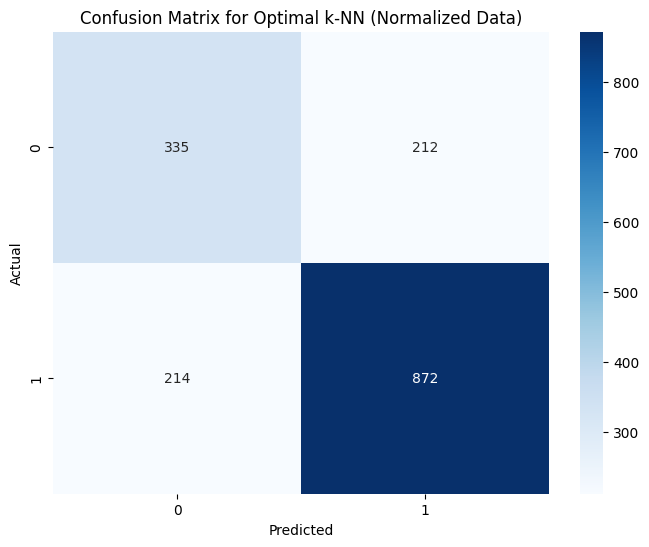

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix for the optimal k-NN model on normalized data
cm = confusion_matrix(Yt, Ypred_test_n)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Optimal k-NN (Normalized Data)')
plt.show()


### Summary of Findings

**Impact of Data Normalization:**

As observed previously, data normalization significantly improved the k-NN model's performance. The test error rate for the optimal `k=1` decreased from **0.3215 (32.15%) without normalization** to **0.2609 (26.09%) with normalization**. This reduction of approximately 6 percentage points highlights that scaling features to have zero mean and unit variance made the distance metric used by k-NN more effective, leading to better classification accuracy. This is crucial for distance-based algorithms like k-NN, as features with larger ranges can disproportionately influence distance calculations without standardization.

**Insights from the Confusion Matrix (Normalized Data):**

The confusion matrix for the optimal k-NN model trained on normalized data (`k=1`) is:

```
[[335, 212],
 [214, 872]]
```

Where:
*   **True Negatives (TN):** 335 (Correctly predicted as class 0 - 'bad' wine)
*   **False Positives (FP):** 212 (Incorrectly predicted as class 1 - 'good' wine, when actual was class 0)
*   **False Negatives (FN):** 214 (Incorrectly predicted as class 0 - 'bad' wine, when actual was class 1)
*   **True Positives (TP):** 872 (Correctly predicted as class 1 - 'good' wine)

From these values, we can infer:
*   **Accuracy:** (335 + 872) / (335 + 212 + 214 + 872) = 1207 / 1633 ≈ 0.7391 (or 73.91%), which aligns with the calculated test error of 1 - 0.2609 = 0.7391.
*   The model performs reasonably well, with a higher number of true positives and true negatives compared to false positives and false negatives.
*   There is a relatively balanced misclassification between class 0 and class 1, meaning the model is roughly as likely to misclassify a 'bad' wine as 'good' (FP) as it is to misclassify a 'good' wine as 'bad' (FN).

## Final Task

### Subtask:
Provide a summary of the analysis, including the model performance comparison and the insights gained from the confusion matrix.


## Summary:

### Q&A
1.  **How does data normalization impact the k-NN model's performance?**
    Data normalization significantly improved the k-NN model's performance. The test error rate for the optimal k=1 decreased from 0.3215 (32.15%) without normalization to 0.2609 (26.09%) with normalization. This reduction of approximately 6.06 percentage points indicates that standardizing the data made the distance metric used by k-NN more effective, leading to better classification accuracy.

2.  **What does the confusion matrix for the optimal k-NN model (trained on normalized data) reveal about its classification performance?**
    The confusion matrix for the optimal k-NN model on normalized data shows:
    *   335 True Negatives (correctly predicted as class 0 - 'bad' wine).
    *   212 False Positives (incorrectly predicted as class 1 - 'good' wine, when actual was class 0).
    *   214 False Negatives (incorrectly predicted as class 0 - 'bad' wine, when actual was class 1).
    *   872 True Positives (correctly predicted as class 1 - 'good' wine).
    This translates to an overall accuracy of approximately 73.91%. The model exhibits a relatively balanced misclassification pattern between the two classes.

### Data Analysis Key Findings
*   Data normalization reduced the k-NN model's test error rate from 32.15% to 26.09%, representing a significant improvement of 6.06 percentage points.
*   For the optimal k-NN model (k=1) on normalized data, the confusion matrix showed 335 True Negatives, 212 False Positives, 214 False Negatives, and 872 True Positives.
*   The overall accuracy of the optimal k-NN model on normalized data is approximately 73.91%.
*   The model's misclassifications are relatively balanced between the two classes, with 212 instances of 'bad' wine being misclassified as 'good' and 214 instances of 'good' wine being misclassified as 'bad'.

### Insights or Next Steps
*   Data normalization is crucial for distance-based algorithms like k-NN, as it prevents features with larger ranges from disproportionately influencing distance calculations and leads to more effective model performance.
*   Further analysis could involve exploring different normalization techniques or feature engineering to potentially reduce the balanced misclassification rates observed in the confusion matrix, aiming to further improve overall model accuracy and minimize specific types of classification errors.
